In [1]:
from utils.mnist import MNIST, MNIST_NORMALIZATION
from utils.emnist import EMNIST
from utils.fmnist import FashionMNIST
from core.mln.mixture_head import mln_cnn
from core.mln.func import mace_loss,mln_gather,mln_uncertainties
from torchvision import datasets,transforms
import torch
import numpy as np
from utils.score import plot
import matplotlib.pyplot as plt

## OOD as EMNIST or FMNIST

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,mode = 'all',transform=tf)
test_id = MNIST('./dataset/', download=True,mode = 'all',transform=tf,train=False)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=True)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=True)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=True)

In [3]:
model = mln_cnn(y_dim=10,sig_min=1,sig_max=2,
                mu_min=-3,mu_max=3,k=10).to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, 
                weight_decay=1e-4)


### Training

In [4]:
from torch.nn.modules.loss import _Loss
model.train()
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        label = torch.eye(10)[label]
        loss_out = mace_loss(out['pi'],out['mu'],out['sigma'],label.to('cuda'))
        loss = loss_out['mace_avg'] - 1e-4* loss_out['epis_avg'] + 1*loss_out['alea_avg']
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)
    print(loss_out['mace_avg'].item(), 
            loss_out['epis_avg'].item(), loss_out['alea_avg'].item())

tensor(1.1526, device='cuda:0', grad_fn=<AddBackward0>)
0.1507149636745453 0.01360955648124218 1.001894235610962
tensor(1.1590, device='cuda:0', grad_fn=<AddBackward0>)
0.15817470848560333 0.0065345196053385735 1.0008326768875122
tensor(1.0249, device='cuda:0', grad_fn=<AddBackward0>)
0.02453547529876232 0.004741491284221411 1.000394582748413
tensor(1.0459, device='cuda:0', grad_fn=<AddBackward0>)
0.04570765420794487 0.00411005737259984 1.0002169609069824
tensor(1.0948, device='cuda:0', grad_fn=<AddBackward0>)
0.09455722570419312 0.004197311587631702 1.0002230405807495


### Test Accuracy

In [5]:
model.eval()
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        out = mln_gather(out['pi'],out['mu'],out['sigma'])
        _,pred_logit = torch.max(out['mu_sel'],dim=-1)
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9862


### Uncertainty

In [6]:
in_alea = np.zeros((0))
in_epis = np.zeros((0))
with torch.no_grad():
    for image,label in test_id_loader:
        out = model(image.to('cuda'))
        unct = mln_uncertainties(out['pi'],out['mu'],out['sigma'])
        in_epis = np.concatenate((in_epis,unct['epis'].cpu().numpy()))
        in_alea = np.concatenate((in_alea,unct['alea'].cpu().numpy()))
print(np.mean(in_epis),np.mean(in_alea))

out_near_alea = np.zeros((0))
out_near_epis = np.zeros((0))
with torch.no_grad():
    for image,label in test_near_ood_loader:
        out = model(image.to('cuda'))
        unct = mln_uncertainties(out['pi'],out['mu'],out['sigma'])
        out_near_epis = np.concatenate((out_near_epis,unct['epis'].cpu().numpy()))
        out_near_alea = np.concatenate((out_near_alea,unct['alea'].cpu().numpy()))

print(np.mean(out_near_epis),np.mean(out_near_alea))


out_far_alea = np.zeros((0))
out_far_epis = np.zeros((0))
with torch.no_grad():
    for image,label in test_far_ood_loader:
        out = model(image.to('cuda'))
        unct = mln_uncertainties(out['pi'],out['mu'],out['sigma'])
        out_far_epis = np.concatenate((out_far_epis,unct['epis'].cpu().numpy()))
        out_far_alea = np.concatenate((out_far_alea,unct['alea'].cpu().numpy()))
print(np.mean(out_far_epis),np.mean(out_far_alea))


0.0022774684366020665 1.0000815656900406
0.007260433256878794 1.000801191673829
0.013074560309856861 1.0009900793075561


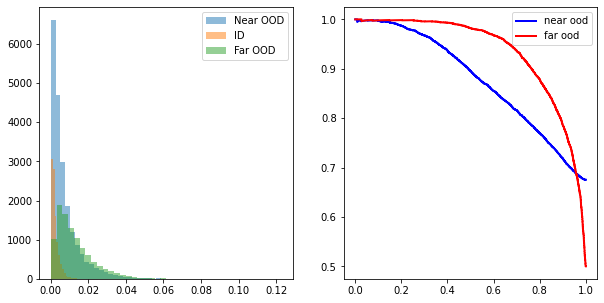

Near AUROC:0.7534677067307692, Far AUROC: 0.9251906700000001


In [7]:
auroc = plot(in_epis,out_near_epis, out_far_epis,name='Epis',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

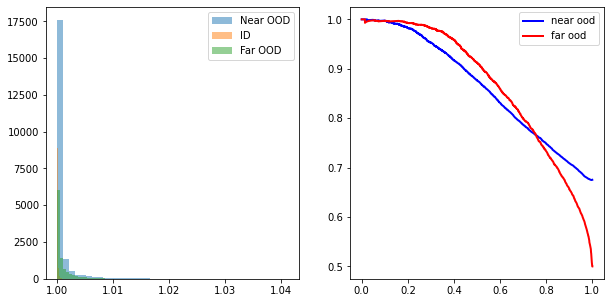

Near AUROC:0.7281324447115385, Far AUROC: 0.8510813100000001


In [8]:
auroc = plot(in_alea,out_near_alea, out_far_alea,name='Alea',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

## Calibration